In [1]:
import os
import json
import pandas as pd
import numpy as np
from typing import Dict
from pandas.api.types import is_numeric_dtype
from itertools import combinations
from collections import Counter


import curvlearn as cv
from curvlearn.manifolds.manifold import Manifold
import torch
import torch.nn as nn
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from diffpool_helpers.model.diffpool_continuous import TSDiffPool
import argparse
import time
import random
import yfinance
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import timedelta
import datetime
import requests
from math import floor
import dgl
from eodhd import APIClient
from sklearn.preprocessing import StandardScaler

In [ ]:
symbols_dict = {}

files = os.listdir('./symbols_data_raw')

for file in files:
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join('./symbols_data_raw', file))
        symbols_dict[file.split('_')[0]] = df

KeyboardInterrupt: 

In [ ]:
dt = symbols_dict

# Fix NaNs

In [ ]:
for k in symbols_dict:
    symbols_dict[k].replace('N/A', np.nan, inplace=True)

# Fix indices

In [ ]:
for symbol, df in symbols_dict.items():
    if isinstance(df.index, pd.PeriodIndex): continue
    if df.index.equals(pd.RangeIndex(len(df))): # if index is numbers
        df.index = df["date"]
    new_index = []  # Store modified indices
    for row in df.index:
        if isinstance(row, int) or isinstance(row, float) or pd.isna(row):
            new_index.append("1969Q1") # quarter string not in dataset to flag for dropping
            continue
        if row.startswith('Q') and len(row) == 6 and row[2:].isdigit():  
            new_index.append(row[2:] + row[0:2])  
        else:
            if row[:4].isdigit() and row[-1].isdigit(): # check valid format
                new_index.append(row)  # append
            elif row == "CY2010": # found several weird indices in dataset; treat as Q1 of year
                new_index.append("2010Q1")
            elif row == "2012CY":
                new_index.append("2012Q1")
            elif row == "2010CY":
                new_index.append("2010Q2")
            elif row == "2019CY":
                new_index.append("2019Q1")
            elif row == "2011CY":
                new_index.append("2011Q1")
            elif row == "2011CY":
                new_index.append("")
            else:
                print(f"Invalid index format: {row}. Skipping this row.")  
    df.index = new_index 

In [ ]:
# drop symbols flagged for dropping
for k in symbols_dict: 
    if "1969Q1" in symbols_dict[k].index:
        symbols_dict[k] = symbols_dict[k].drop("1969Q1")

In [ ]:
dt = symbols_dict

## Sort and de-dupe index

In [ ]:
for k in symbols_dict:
    symbols_dict[k] = symbols_dict[k][~symbols_dict[k].index.isna()]
    symbols_dict[k] = symbols_dict[k].sort_index()
    dt[k] = dt[k][~dt[k].index.duplicated(keep='first')]

# Add any missing rows

In [ ]:
def add_missing_rows(df):
    """
    Fills in missing quarters in a DataFrame with indices of the form "YYYYQq".

    Args:
        df (pandas.DataFrame): The DataFrame to fill in.

    Returns:
        pandas.DataFrame: The DataFrame with missing quarters filled in.
    """  

    min_year = int(df.index.str.slice(0, 4).min())
    max_year = int(df.index.str.slice(0, 4).max())
    all_quarters = pd.period_range(start=f'{min_year}Q1', end=f'{max_year}Q1', freq='Q-DEC')
    try:
        df = df.reindex(all_quarters.astype(str)) 
    except Exception as e:
        print(f"Exception occurred: {e}. df.index: {df.index}")
        print(f"Duplicate indices are: {df.index[df.index.duplicated()]}")
    return df

In [ ]:
for k in dt:
    dt[k] = add_missing_rows(dt[k])

# Merge columns

In [ ]:
def merge_equivalent_columns(df, symbol):
    """
    Merges columns in a DataFrame that can be written as {symbol}:{col1} and {col1},
    picking one of the non-null values for each pair.
    
    Args:
        df (pandas.DataFrame): The input DataFrame.
        symbol (str): The symbol to look for in the column names.
    
    Returns:
        pandas.DataFrame: The DataFrame with merged columns.
    """
    # Create a dictionary to store the column pairs
    column_pairs = {}
    
    # Iterate through the columns
    for col in df.columns:
        if col.startswith(f"{symbol}:"):
            base_col = col[len(f"{symbol}:"):]
            if base_col in df.columns:
                column_pairs[base_col] = col
    for base_col, pair_col in column_pairs.items():
        df[base_col] = df[[base_col, pair_col]].fillna(method='ffill', axis=1)[base_col]
        df = df.drop(pair_col, axis=1)
    
    return df

In [ ]:
for k in dt:
    dt[k] = merge_equivalent_columns(dt[k], k)

# Impute or Drop

In [ ]:
x = 0
def sliding_window_imputation(df, symbol=""):
    global x
    # print(df.index)
    if not df.index.equals(pd.RangeIndex(len(df))): # need to reset index
        if "date" in df.columns:
            df = df.drop("date", axis=1) 
        df.reset_index(inplace=True)
    for col in df.columns:
        if col == "date" or not df[col].isna().any(): continue
        if col == "period":
            df = df.drop(columns=[col])
            continue
        # impute
        if is_numeric_dtype(df[col]) and df[col].isna().any() and df[col].count() / len(df) > 0.75:
            nan_indices = df[col].isna()
            non_nan_indices = ~nan_indices

            l = non_nan_indices[non_nan_indices].index[0]
            r = l + 1
            df.loc[:l, col] = df.loc[l, col]
            last_def = non_nan_indices[non_nan_indices].index[-1]
            while r < last_def:
                if non_nan_indices[l] and non_nan_indices[r]:
                    l += 1
                    r += 1
                else:
                    while r < last_def and nan_indices[r]:
                        r += 1
                    data_segment = df[col][l:r+1]  # Extract the relevant data segment
                    imputation_mean = data_segment.mean()  # Calculate the mean
                    df.loc[l + 1:r - 1, col] = imputation_mean  # Fill missing values with the mean
                    l, r = r, r + 1
            if r < last_def:
                df.loc[r:, col] = df.loc[r, col]
            # check that imputation worked
            if df[col].isna().any():
                # TODO -> HIGHLY SUS
                # print(f"Column {col} ({symbol}) has {df[col].isna().sum()} null values.")
                df[col] = df[col].fillna(df[col].mean())
        else:
            df = df.drop(columns=[col])
    if "index" in df.columns:
        df = df.set_index("index")  
    elif "date" in df.columns:
        df = df.set_index("date") 
    else:
        # print(f"FRICK!")
        x += 1
    if df.isnull().values.any():
        print("Dataframe still has null values.")
    return df

In [ ]:
for k in symbols_dict:
    symbols_dict[k] = sliding_window_imputation(symbols_dict[k], k)

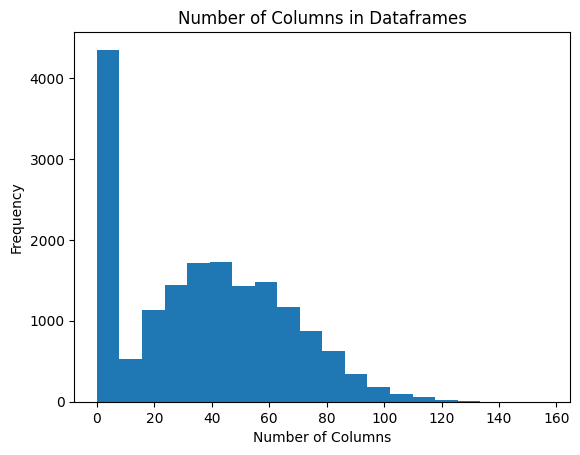

In [ ]:
import matplotlib.pyplot as plt

# Count the number of columns in each dataframe
num_columns = [len(df.columns) for df in symbols_dict.values()]

# Plot a histogram
plt.hist(num_columns, bins=20)
plt.title('Number of Columns in Dataframes')
plt.xlabel('Number of Columns')
plt.ylabel('Frequency')
plt.show()


In [ ]:
len(dt)

17186

# Export for Next Step

In [ ]:
dt = symbols_dict

In [ ]:
# Drop dataframes with fewer than 10 rows
dt = {k: v for k, v in dt.items() if len(v) >= 7}

In [ ]:
len(dt)

10438

In [ ]:
all_cols = np.concatenate([df.columns for df in dt.values()])
counts = Counter(all_cols)

In [ ]:
counts.keys()

dict_keys(['index', 'CashAndCashEquivalentsAtCarryingValue', 'AvailableForSaleSecuritiesCurrent', 'InventoryNet', 'PrepaidExpenseCurrent', 'OtherReceivablesNetCurrent', 'AssetsCurrent', 'PropertyPlantAndEquipmentNet', 'SecurityDeposit', 'Assets', 'AccountsPayableCurrent', 'AccruedSalesCommissionCurrent', 'OtherLiabilitiesCurrent', 'CustomerAdvancesCurrent', 'PreferredStockValue', 'CommonStockValue', 'AdditionalPaidInCapitalCommonStock', 'RetainedEarningsAccumulatedDeficit', 'AccumulatedOtherComprehensiveIncomeLossNetOfTax', 'StockholdersEquity', 'MinorityInterest', 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest', 'LiabilitiesAndStockholdersEquity', 'ProfitLoss', 'DepreciationAndAmortization', 'AvailableforsaleSecuritiesGrossRealizedGainLossExcludingOtherThanTemporaryImpairments', 'IncreaseDecreaseInInventories', 'IncreaseDecreaseInAccountsPayable', 'eftb:IncreaseDecreaseInCommissionPayable', 'IncreaseDecreaseInOtherCurrentLiabilities', 'eftb:IncreaseDecreaseInU

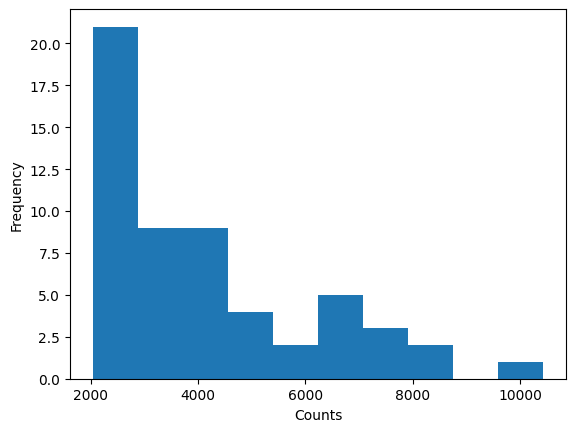

In [ ]:
counts_above_10 = [v for k, v in counts.items() if v > 2000]
col_set = set([k for k, v in counts.items() if v > 2000])

plt.hist(counts_above_10)
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()

In [ ]:
col_set

{'AccountsPayableCurrent',
 'AccountsReceivableNetCurrent',
 'AccruedLiabilitiesCurrent',
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax',
 'AdditionalPaidInCapital',
 'AdditionalPaidInCapitalCommonStock',
 'Assets',
 'AssetsCurrent',
 'CashAndCashEquivalentsAtCarryingValue',
 'CashAndCashEquivalentsPeriodIncreaseDecrease',
 'CommonStockValue',
 'ComprehensiveIncomeNetOfTax',
 'DepreciationDepletionAndAmortization',
 'EarningsPerShareBasic',
 'EarningsPerShareBasicAndDiluted',
 'EarningsPerShareDiluted',
 'GeneralAndAdministrativeExpense',
 'Goodwill',
 'GrossProfit',
 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest',
 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments',
 'IncomeTaxExpenseBenefit',
 'IncreaseDecreaseInAccountsPayable',
 'IncreaseDecreaseInAccountsPayableAndAccruedLiabilities',
 'IncreaseDecreaseInAccountsReceivable',
 'IncreaseDecreaseInInventories',
 'IncreaseDecr

In [ ]:
counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

In [ ]:
col_set |= {"index"}
# filtered_dt = {key: df.loc[:, list(col_set.intersection(df.columns))] for key, df in dt.items() if col_set.issubset(set(df.columns))}

In [ ]:
filtered_dt = {}
for k, df, in dt.items():
    intersect_size = len(set(df.columns).intersection(col_set))
    if intersect_size > 30:
        filtered_dt[k] = df[list(col_set.intersection(df.columns))]

In [ ]:
for k in filtered_dt:
    filtered_dt[k].index = filtered_dt[k]["index"]

In [ ]:
if not os.path.exists('./imputed_data'):
    os.makedirs('./imputed_data')
for symbol, data in filtered_dt.items():
    data.to_csv(f'./imputed_data/{symbol}_data.csv')